# Library initialization and data import
- Libraries needed for data preprocessing and missing data correction

- Weihenstephan weather data from 2021 imported from DWD CDC server: 
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/


In [1]:
import os
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


In [65]:
import glob as gb
#### Import data from DWD server
path_dwd = ('files/dwd_weihenstephan/*.txt')
pathlist_dwd = gb.glob(path_dwd)

#time limit
startdate = "2021-01-01"
enddate = "2021-12-31"

#Initialize dictionary
dict_dwd = {}

#Loop over txt files
for p in pathlist_dwd:
    """
    - n -
    V_N_I = Sky cover index, boolean
    V_N = Total sky cover, 1/8

    - ff - 
    FF_10 = Average wind speed, in m/s
    DD_10 = Average wind direction, in deg

    - rr -
    RWS_DAU_10 = Rain duration, in minutes
    RWS_10 = Liquid precipitation depth, in mm
    RWS_IND_10 = Rain indicator, boolean

    - sd -
    DS_10 = Diffuse horizontal radiation, in J/cm^2
    GS_10 = Global horizontal radiation, in J/cm^2
    SD_10 = Sunshine duration, in h
    LS_10 = Longwave radiation, in J/cm^2

    - tu -
    PP_10 = Air pressure, in hPa
    TT_10 = Dry-bulb temperature air, in °C
    TM5_10 = Air temperature at 5 cm, in °C
    RF_10 = Relative humidity, in %
    TD_10 = Dew point temperature air, in °C
    """
    if (p.split('_')[-4] == 'stunde'):
        name = p.split('_')[-5]
        keytxt = p.split('_')[2]
    else:
        name = p.split('_')[-4]
        keytxt = p.split('_')[4]

    dict_dwd[name] = pd.read_csv(p, sep=";", decimal  ='.')
    dict_dwd[name].index = pd.to_datetime(dict_dwd[name].MESS_DATUM,format="%Y%m%d%H%M")
    dict_dwd[name] = dict_dwd[name].drop(columns =["STATIONS_ID",
                                                   "MESS_DATUM",
                                                   dict_dwd[name].columns[dict_dwd[name].columns.str.contains("QN")][0],
                                                   "eor"])

    dict_dwd[name] = dict_dwd[name][startdate:enddate]

    #Correct missing values 
    for i in range(len(dict_dwd[name].columns)):
        dict_dwd[name].iloc[:,i][dict_dwd[name].iloc[:,i] == -999]= pd.NA
        dict_dwd[name].iloc[:,i] = dict_dwd[name].iloc[:,i].interpolate(method='linear', axis=0)
    

<ipython-input-65-0a2497a5acbd>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_dwd[name].iloc[:,i][dict_dwd[name].iloc[:,i] == -999]= pd.NA
<ipython-input-65-0a2497a5acbd>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_dwd[name].iloc[:,i][dict_dwd[name].iloc[:,i] == -999]= pd.NA
<ipython-input-65-0a2497a5acbd>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_dwd[name].iloc[:,i][dict_dwd[name].iloc[:,i] == -999]= p

# Histogram for different measured variables. 

The goal is to understand the distribution of the online measured data.

array([[<AxesSubplot:title={'center':'PP_10'}>,
        <AxesSubplot:title={'center':'TT_10'}>],
       [<AxesSubplot:title={'center':'TM5_10'}>,
        <AxesSubplot:title={'center':'RF_10'}>],
       [<AxesSubplot:title={'center':'TD_10'}>, <AxesSubplot:>]],
      dtype=object)

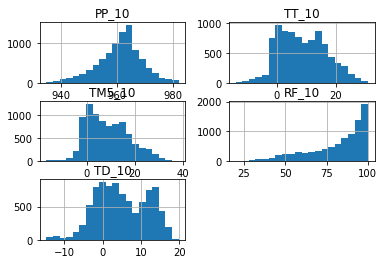

In [68]:
dict_dwd['tu'].resample('H').mean().hist(bins=20)


array([[<AxesSubplot:title={'center':'DS_10'}>,
        <AxesSubplot:title={'center':'GS_10'}>],
       [<AxesSubplot:title={'center':'SD_10'}>,
        <AxesSubplot:title={'center':'LS_10'}>]], dtype=object)

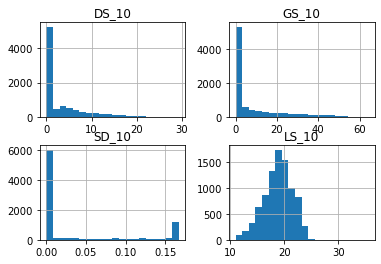

In [67]:
dict_dwd['sd'].resample('H').mean().hist(bins=20)


# For the missing solar radiation, a kernel ridge regression is used to estimate the missing data. 

Different missing data periods are observed for global and diffuse radiation. 

The periodicity of the solar radiation every day and every year makes it suitable for RBF kernels (gaussian distribution against the hour, piecewise linear against the solar zenith angle, sigmoid shape against the dry-bulb temperature).


In [69]:
from sklearn import kernel_ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
'''
Global solar radiation (GS) Missing data -> 2021-06-30:2021-07-11
Diffuse solar radiation (DS) Missing data -> 2021-06-30:2021-07-26
'''
## Solar zenith angle calculation
latitude = np.radians(48.4024)
h = (dict_dwd['tu'].TT_10.resample('H').mean().index.hour -12)/12
angle_declination = 23.45*np.sin(np.radians(360*(284+(dict_dwd['tu'].resample('H').mean().index.day_of_year-1))/365))
solar_zenith_angle = np.sin(latitude)*np.sin(np.radians(angle_declination)) + \
    np.cos(latitude)*np.cos(np.radians(angle_declination))*np.cos(h)

SZA = pd.DataFrame({'SZA': solar_zenith_angle})
SZA.index = dict_dwd['tu'].TT_10.resample('H').mean().index

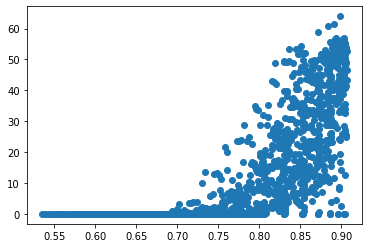

In [70]:
#Scatter plot solar zenith angle vs. global radiation
plt.scatter(SZA.SZA['2021-05':'2021-06'],
            dict_dwd['sd'].GS_10.resample('H').mean()['2021-05':'2021-06'])

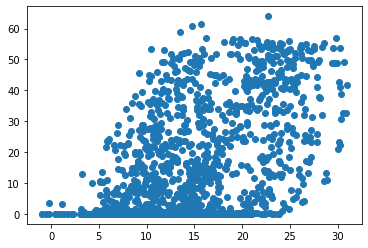

In [442]:
#Scatter plot temperature vs. global radiation
plt.scatter(dict_dwd['tu'].TT_10.resample('H').mean()['2021-05':'2021-06'],
            dict_dwd['sd'].GS_10.resample('H').mean()['2021-05':'2021-06'])

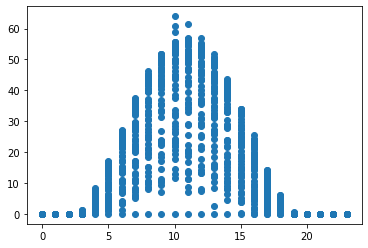

In [443]:
#Scatter plot hour of the day vs. global radiation
plt.scatter(SZA.SZA['2021-05':'2021-06'].index.hour,
            dict_dwd['sd'].GS_10.resample('H').mean()['2021-05':'2021-06'])

The data is split in training and test data set. The training data set are the two months before the data is missing, and the test data set are the two months after the data is missing. The model hyperparameters are tuned using these data sets, and then the missing data points are estimated using the trained model. 

A value correction function is introduced to avoid negative solar radiation values (there were some slightly negative values observed after the regression, up to -2). 

In [73]:
x_train = pd.DataFrame({'Temp': dict_dwd['tu'].TT_10.resample('H').mean()['2021-05-01':'2021-06-29'].values, 
    'Hour': dict_dwd['tu'].TT_10.resample('H').mean()['2021-05-01':'2021-06-29'].index.hour.values,
    'SZA': SZA['2021-05-01':'2021-06-29'].SZA.values})
y_train = dict_dwd['sd'].GS_10.resample('H').mean()['2021-05-01':'2021-06-29'].values

x_test = pd.DataFrame({'Temp': dict_dwd['tu'].TT_10.resample('H').mean()['2021-07-12':'2021-08-30'].values, 
    'Hour': dict_dwd['tu'].TT_10.resample('H').mean()['2021-07-12':'2021-08-30'].index.hour.values,
    'SZA': SZA['2021-07-12':'2021-08-30'].SZA.values})
y_test = dict_dwd['sd'].GS_10.resample('H').mean()['2021-07-12':'2021-08-30'].values

In [74]:
#KernelRidge regression with sklearn
regr = make_pipeline(StandardScaler(), kernel_ridge.KernelRidge(kernel='rbf', alpha=0.9, gamma=0.3))
regr.fit(x_train, y_train)
regr_y_pred = regr.predict(x_test)
print("Root mean squared error: %.2f" % mean_squared_error(y_test, regr_y_pred)**(0.5))
print("R_squared score: %.2f" % regr.score(x_test, y_test))


Root mean squared error: 7.39
R_squared score: 0.77


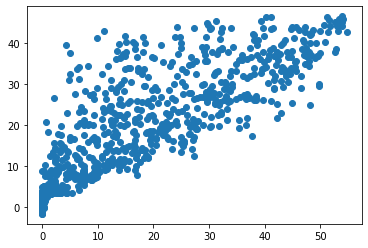

In [376]:
plt.scatter(y_test, regr_y_pred)

<AxesSubplot:xlabel='MESS_DATUM'>

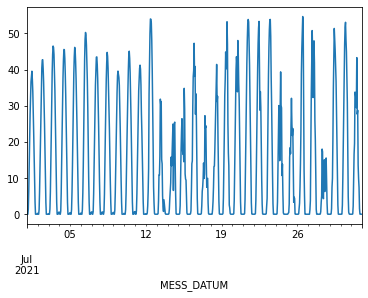

In [75]:
# Real data prediction
x_test_missingdata = pd.DataFrame({'Temp': dict_dwd['tu'].TT_10.resample('H').mean()['2021-06-30':'2021-07-11'].values, 
    'Hour': dict_dwd['tu'].TT_10.resample('H').mean()['2021-06-30':'2021-07-11'].index.hour.values,
    'SZA': SZA['2021-06-30':'2021-07-11'].SZA.values})
regr_y_pred_missingdata = regr.predict(x_test_missingdata)
new_GS_data = dict_dwd['sd'].GS_10.resample('H').mean()
new_GS_data['2021-06-30':'2021-07-11'] = regr_y_pred_missingdata
new_GS_data['2021-06-30':'2021-07-11'][new_GS_data['2021-06-30':'2021-07-11'] <0 ] = 0
#Plot missing data
new_GS_data['2021-07'].plot()

In [76]:
#Repeat with diffuse radiation
x_train = pd.DataFrame({'Temp': dict_dwd['tu'].TT_10.resample('H').mean()['2021-05-01':'2021-06-29'].values, 
    'Hour': dict_dwd['tu'].TT_10.resample('H').mean()['2021-05-01':'2021-06-29'].index.hour.values,
    'GS': new_GS_data['2021-05-01':'2021-06-29'].values,
    'SZA': SZA['2021-05-01':'2021-06-29'].SZA.values})
y_train = dict_dwd['sd'].DS_10.resample('H').mean()['2021-05-01':'2021-06-29'].values

x_test = pd.DataFrame({'Temp': dict_dwd['tu'].TT_10.resample('H').mean()['2021-07-27':'2021-08-30'].values, 
    'Hour': dict_dwd['tu'].TT_10.resample('H').mean()['2021-07-27':'2021-08-30'].index.hour.values,
    'GS': new_GS_data['2021-07-27':'2021-08-30'].values,
    'SZA': SZA['2021-07-27':'2021-08-30'].SZA.values})
y_test = dict_dwd['sd'].DS_10.resample('H').mean()['2021-07-27':'2021-08-30'].values

In [77]:
#KernelRidge regression with sklearn
regr = make_pipeline(StandardScaler(), kernel_ridge.KernelRidge(kernel='rbf', alpha=0.1, gamma=0.5))
regr.fit(x_train, y_train)
regr_y_pred = regr.predict(x_test)
print("Root mean squared error: %.2f" % mean_squared_error(y_test, regr_y_pred)**(0.5))
print("R_squared score: %.2f" % regr.score(x_test, y_test))

Root mean squared error: 2.51
R_squared score: 0.85


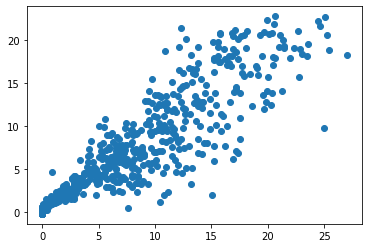

In [452]:
plt.scatter(y_test, regr_y_pred)

<AxesSubplot:xlabel='MESS_DATUM'>

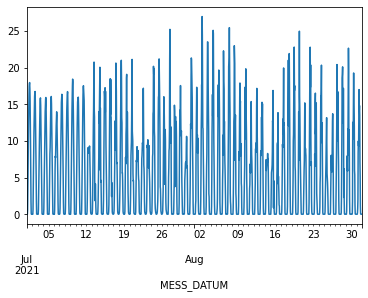

In [78]:
# Real data prediction
x_test_missingdata = pd.DataFrame({'Temp': dict_dwd['tu'].TT_10.resample('H').mean()['2021-06-30':'2021-07-26'].values, 
    'Hour': dict_dwd['tu'].TT_10.resample('H').mean()['2021-06-30':'2021-07-26'].index.hour.values,
    'GS': new_GS_data['2021-06-30':'2021-07-26'].values,
    'SZA': SZA['2021-06-30':'2021-07-26'].SZA.values})
regr_y_pred_missingdata = regr.predict(x_test_missingdata)
new_DS_data = dict_dwd['sd'].DS_10.resample('H').mean()
new_DS_data['2021-06-30':'2021-07-26'] = regr_y_pred_missingdata
new_DS_data['2021-06-30':'2021-07-26'][new_DS_data['2021-06-30':'2021-07-26'] <0 ] = 0
#Plot missing data
new_DS_data['2021-07':'2021-08'].plot()

# Create new .epw weather file for Weihenstephan (year 2021) with:
- DWD measurements
- Data estimation (Wet bulb temperature)
- Filled data points (Global and diffuse solar radiation)

The .epw file is created using the software Elements. The timeseries.csv is edited. 

In [71]:
path_elements = ('files/timeseries.csv')
elements_weihenstephan = pd.read_csv(path_elements, sep=",", decimal  ='.')
elements_weihenstephan.columns #see variables to modify

Index(['Unnamed: 0', 'Unnamed: 0.1', 'cloudCover', ' dryBulbTemp_C',
       ' elapsedTime_hrs', ' horizInfraredSolarRadFromSky_Wh__m2',
       ' pressure_kPa', ' solarBeamNormal_Wh__m2', ' solarDiffuseHoriz_Wh__m2',
       ' wetBulbTemp_C', ' windDirection_deg', ' windSpeed_m__s',
       ' relativeHumidity_%', ' dewPointTemp_C'],
      dtype='object')

In [79]:
# Wet-bulb temperature estimation
T = dict_dwd['tu'].TT_10.resample('H').mean()
rh =  dict_dwd['tu'].RF_10.resample('H').mean()
T_wb = T * np.arctan(0.152*(rh + 8.3136)**(1/2)) + np.arctan(T+rh) + \
         0.00391838*(rh)**(3/2) * np.arctan(0.0231*rh) - 4.686 - np.arctan(rh-1.6763) 
         
# Estimation of solar zenith angle to calculate normal solar beam
# Estimation source -> http://www.diva-portal.org/smash/get/diva2:1329374/FULLTEXT01.pdf
latitude = np.radians(48.4024)
h = (dict_dwd['tu'].TT_10.resample('H').mean().index.hour -12)/12
angle_declination = 23.45*np.sin(np.radians(360*(284+(dict_dwd['tu'].resample('H').mean().index.day_of_year-1))/365))
solar_zenith_angle = np.sin(latitude)*np.sin(np.radians(angle_declination)) + \
    np.cos(latitude)*np.cos(np.radians(angle_declination))*np.cos(h)

# Calculation Direct Solar Beam Normal
DNI = ((new_GS_data*10000/3600)- \
         (new_DS_data*10000/3600)) / solar_zenith_angle
DNI[DNI<0] = 0

# Could cover - fill the gaps 
CloudCover = dict_dwd['tu'].TT_10.resample('H').mean()
CloudCover[dict_dwd['n'].loc[:,' V_N'].resample('H').mean().index] =  np.floor(dict_dwd['n'].loc[:,' V_N'].resample('H').mean().interpolate(method='linear', axis=0)*10/8)
CloudCover.loc['2021-12-31'] = CloudCover.loc['2021-12-30'].values


In [578]:
# Replace the values with measurements from DWD in Weihenstephan
# Cloud cover - conversion from eights to tenths
elements_weihenstephan.cloudCover = CloudCover.values

# Dry-bulb temperature
elements_weihenstephan.loc[:,' dryBulbTemp_C'] = np.round(dict_dwd['tu'].TT_10.resample('H').mean().values, decimals=2)

# Longwave radiation - converstion from J/cm2 to Wh/m2
elements_weihenstephan.loc[:,' horizInfraredSolarRadFromSky_Wh__m2'] = np.round(dict_dwd['sd'].LS_10.resample('H').mean().values*10000/3600, decimals=2)

# Air pressure
elements_weihenstephan.loc[:,' pressure_kPa'] = np.round(dict_dwd['tu'].PP_10.resample('H').mean().values/10, decimals=2)

# Direct normal radiation
elements_weihenstephan.loc[:,' solarBeamNormal_Wh__m2'] = np.round(DNI.values, decimals=2)

# Diffuse radiation - converstion from J/cm2 to Wh/m2
elements_weihenstephan.loc[:,' solarDiffuseHoriz_Wh__m2'] = np.round(new_DS_data.values*10000/3600, decimals=2)

# Wet-bulb temperature
elements_weihenstephan.loc[:,' wetBulbTemp_C'] = np.round(T_wb.values, decimals=2)

# Wind direction
elements_weihenstephan.loc[:,' windDirection_deg'] = np.floor(dict_dwd['ff'].DD_10.resample('H').mean().values)

# Wind speed
elements_weihenstephan.loc[:,' windSpeed_m__s'] = np.round(dict_dwd['ff'].FF_10.resample('H').mean().values, decimals=2)


In [579]:
elements_weihenstephan.loc[0:20,:]


,Unnamed: 0,cloudCover,dryBulbTemp_C,elapsedTime_hrs,horizInfraredSolarRadFromSky_Wh__m2,pressure_kPa,solarBeamNormal_Wh__m2,solarDiffuseHoriz_Wh__m2,wetBulbTemp_C,windDirection_deg,windSpeed_m__s,relativeHumidity_%,dewPointTemp_C
0,0,8.0,-2.15,0,39.21,94.91,0.00,0.00,-2.82,158.0,1.12,93.12,-3.12
1,1,9.0,-3.10,1,39.54,94.92,0.00,0.00,-3.53,151.0,0.82,96.37,-3.58
2,2,10.0,-3.28,2,43.80,94.92,0.00,0.00,-3.65,140.0,0.60,97.13,-3.67
3,3,9.0,-3.07,3,45.93,94.91,0.00,0.00,-3.51,241.0,0.62,96.13,-3.58
4,4,9.0,-2.97,4,43.10,94.91,0.00,0.00,-3.46,168.0,0.65,95.45,-3.57
5,5,9.0,-3.55,5,42.22,94.93,0.00,0.00,-4.05,278.0,0.57,95.33,-4.18
6,6,9.0,-3.28,6,46.57,94.97,0.00,0.05,-3.69,173.0,0.88,96.60,-3.77
7,7,9.0,-3.15,7,44.17,95.04,0.70,2.55,-3.70,200.0,0.70,94.72,-3.90
8,8,9.0,-2.65,8,44.77,95.08,1.14,7.55,-3.30,225.0,0.33,93.30,-3.60
9,9,9.0,-1.10,9,43.06,95.12,42.49,16.20,-2.45,266.0,0.87,84.05,-3.50


In [541]:
## Double-check if there are NAs 
pd.isna(elements_weihenstephan).sum()


cloudCover                              0
 dryBulbTemp_C                          0
 elapsedTime_hrs                        0
 horizInfraredSolarRadFromSky_Wh__m2    0
 pressure_kPa                           0
 solarBeamNormal_Wh__m2                 0
 solarDiffuseHoriz_Wh__m2               0
 wetBulbTemp_C                          0
 windDirection_deg                      0
 windSpeed_m__s                         0
dtype: int64

In [580]:
## Save to new .csv file
elements_weihenstephan.to_csv(path_elements, sep=",", decimal  ='.')
